<a href="https://colab.research.google.com/github/AlfinaN/Comvis-CNN-/blob/master/Coba_5_Buat_Alfina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifikasi Spesies Reptil Menggunakan Convolutional Neural Network  (CNN)






Reptil adalah salah satu fauna yang banyak terdapat di wilayah Indonesia. Tidak sedikit masyarakat yang memiliki ketertarikan untuk mengetahui lebih jauh mengenai fauna ini guna menambah pengetahuan. Berdasarkan penelitian sebelumnya, diperlukan Deep Learning khususnya metode CNN bagi program komputer untuk mengidentifikasi spesies reptil melalui gambar. Penelitian ini bertujuan untuk mengetahui model yang tepat dalam menghasilkan akurasi tinggi dalam identifikasi spesies reptil. Ribuan gambar dihasilkan melalui prosess augmentasi data terhadap gambar yang ditangkap secara manual.

# 🏗️ Import Necessary Libraries

In [1]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools


# 🤙Create helper functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot



--2023-06-01 06:57:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-01 06:57:58 (68.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 📥Load and Transform Data

In [4]:
# upload dataset reptil
from google.colab import files
uploaded = files.upload()

Saving Dataset.zip to Dataset.zip


In [5]:
!unzip Dataset.zip

Archive:  Dataset.zip
   creating: Dataset/
   creating: Dataset/Albino/
  inflating: Dataset/Albino/Alb_(1).jpg  
  inflating: Dataset/Albino/Alb_(10).jpg  
  inflating: Dataset/Albino/Alb_(11).jpg  
  inflating: Dataset/Albino/Alb_(12).jpg  
  inflating: Dataset/Albino/Alb_(13).jpg  
  inflating: Dataset/Albino/Alb_(14).jpg  
  inflating: Dataset/Albino/Alb_(15).jpg  
  inflating: Dataset/Albino/Alb_(16).jpg  
  inflating: Dataset/Albino/Alb_(17).jpg  
  inflating: Dataset/Albino/Alb_(18).jpg  
  inflating: Dataset/Albino/Alb_(19).jpg  
  inflating: Dataset/Albino/Alb_(2).jpg  
  inflating: Dataset/Albino/Alb_(20).jpg  
  inflating: Dataset/Albino/Alb_(21).jpg  
  inflating: Dataset/Albino/Alb_(22).jpg  
  inflating: Dataset/Albino/Alb_(23).jpg  
  inflating: Dataset/Albino/Alb_(24).jpg  
  inflating: Dataset/Albino/Alb_(25).jpg  
  inflating: Dataset/Albino/Alb_(26).jpg  
  inflating: Dataset/Albino/Alb_(27).jpg  
  inflating: Dataset/Albino/Alb_(28).jpg  
  inflating: Dataset/Albin

# 📅Placing data into a Dataframe

In [6]:
import os
import pandas as pd
from pathlib import Path

image_dir = Path("Dataset")

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))  + list(image_dir.glob(r'**/*.JPEG'))  + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)


In [7]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("Dataset").rglob("*.JPG")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
        print(img_p)


In [8]:
BATCH_SIZE = 32
IMAGE_SIZE = (64, 64)

In [9]:
image_df

,Filepath,Label
0,Dataset/Kembang/Kem_(25).jpg,Kembang
1,Dataset/Kembang/Kem_(30).jpg,Kembang
2,Dataset/Kembang/Kem_(48).jpg,Kembang
3,Dataset/Kembang/Kem_(26).jpg,Kembang
4,Dataset/Kembang/Kem_(8).jpg,Kembang
...,...,...
695,Dataset/Iguana/Igu_(49).jpg,Iguana
696,Dataset/Iguana/Igu_(32).jpg,Iguana
697,Dataset/Iguana/Igu_(9).jpg,Iguana
698,Dataset/Iguana/Igu_(47).jpg,Iguana


In [11]:
# Menghitung jumlah data
jumlah_data = len(image_df)

# Menampilkan jumlah data
print("Jumlah data:", jumlah_data)

Jumlah data: 700


# 🔭Visualizing images from the dataset

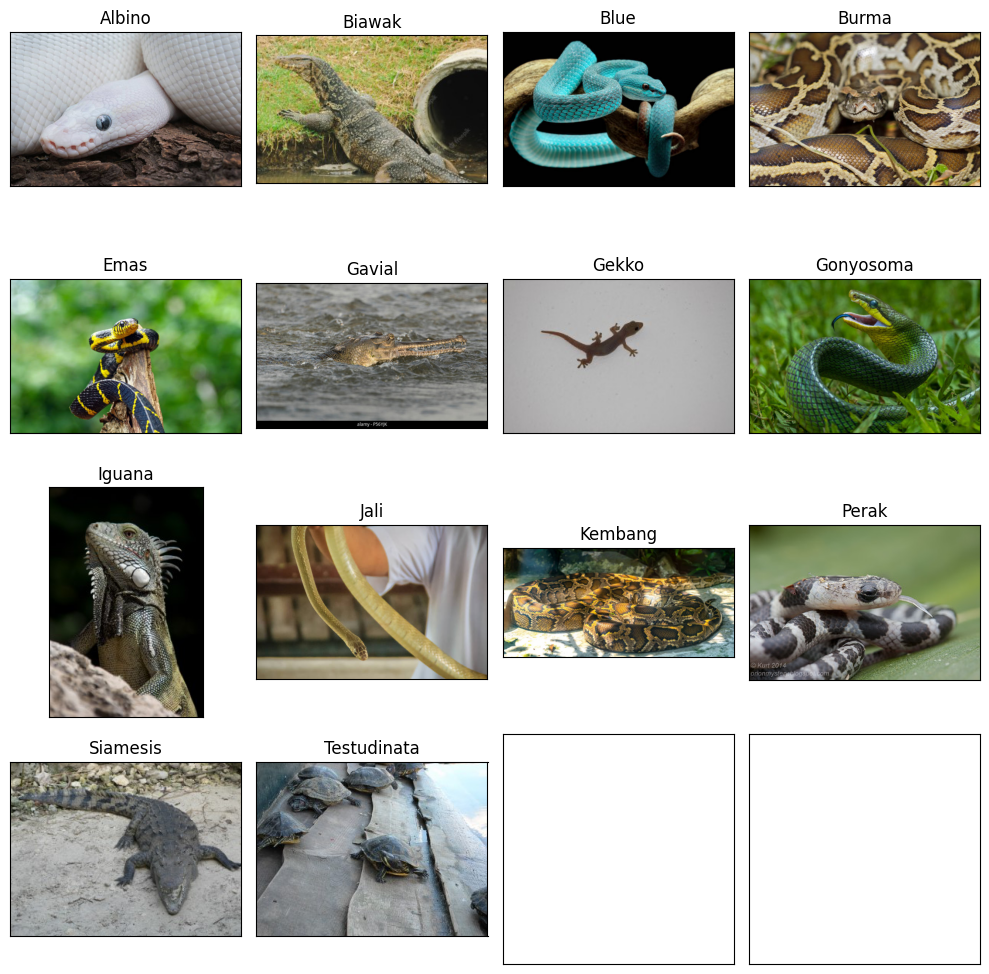

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Pastikan variabel image_df sudah berisi dataframe yang sesuai

# Daftar nama folder jenis reptil
reptile_folders = ['Albino', 'Biawak', 'Blue', 'Burma', 'Emas', 'Gavial', 'Gekko', 'Gonyosoma',
                   'Iguana', 'Jali', 'Kembang', 'Perak', 'Siamesis', 'Testudinata']

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, folder in enumerate(reptile_folders):
    # Ambil filepaths untuk folder tertentu
    filepaths = image_df[image_df['Label'] == folder]['Filepath'].tolist()
    # Ambil 1 gambar secara acak dari setiap folder
    random_image = random.choice(filepaths)
    
    # Tampilkan gambar dan label
    ax = axes.flat[i]
    ax.imshow(plt.imread(random_image))
    ax.set_title(folder)

plt.tight_layout()
plt.show()


# 🚄Data Augmentation

In [13]:
# Menggunakan library Augmentor untuk melakukan proses augmentasi
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
# Tampilkan isi direktori saat ini
print(os.listdir())

['.config', 'Dataset.zip', '__pycache__', 'helper_functions.py', 'Dataset', 'sample_data']


In [15]:
# !rm -rf Dataset/Albino/dataset

In [16]:
import glob
import Augmentor
import os

def perbanyak_(source_dir, sebanyak_ini):
    output_dir = '/dataset/augmented_dataset'
    os.makedirs(output_dir, exist_ok=True)

    p = Augmentor.Pipeline(source_directory=source_dir, output_directory=output_dir)
   
    p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=1)
    p.rotate(probability=0.7, max_left_rotation=13, max_right_rotation=13)
    p.zoom_random(probability=0.5, percentage_area=0.9)
    p.crop_random(probability=0.6, percentage_area=0.9)
    p.resize(probability=1.0, width=64, height=64)
    p.flip_random(probability=0.7)
    p.rotate90(probability=0.5)
    p.rotate270(probability=0.5)
    p.sample(sebanyak_ini)

perbanyak_("Dataset/Albino", 300)
perbanyak_("Dataset/Biawak", 300)
perbanyak_("Dataset/Blue", 300)
perbanyak_("Dataset/Burma", 300)
perbanyak_("Dataset/Emas", 300)
perbanyak_("Dataset/Gavial", 300)
perbanyak_("Dataset/Gekko", 300)
perbanyak_("Dataset/Gonyosoma", 300)
perbanyak_("Dataset/Iguana", 300)
perbanyak_("Dataset/Jali", 300)
perbanyak_("Dataset/Kembang", 300)
perbanyak_("Dataset/Perak", 300)
perbanyak_("Dataset/Siamesis", 300)
perbanyak_("Dataset/Testudinata", 300)

perbanyak_("Dataset/Albino", 2700)
perbanyak_("Dataset/Biawak", 2700)
perbanyak_("Dataset/Blue", 2700)
perbanyak_("Dataset/Burma", 2700)
perbanyak_("Dataset/Emas", 2700)
perbanyak_("Dataset/Gavial", 2700)
perbanyak_("Dataset/Gekko", 2700)
perbanyak_("Dataset/Gonyosoma", 2700)
perbanyak_("Dataset/Iguana", 2700)
perbanyak_("Dataset/Jali", 2700)
perbanyak_("Dataset/Kembang", 2700)
perbanyak_("Dataset/Perak", 2700)
perbanyak_("Dataset/Siamesis", 2700)
perbanyak_("Dataset/Testudinata", 2700)


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA90FF3850>: 100%|██████████| 300/300 [00:28<00:00, 10.54 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA9109BF40>: 100%|██████████| 300/300 [01:01<00:00,  4.85 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA90FBC100>: 100%|██████████| 300/300 [00:23<00:00, 12.85 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA9109A0B0>: 100%|██████████| 300/300 [00:19<00:00, 15.53 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA9170BE50>: 100%|██████████| 300/300 [00:54<00:00,  5.47 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA91081D80>: 100%|██████████| 300/300 [01:39<00:00,  3.01 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA917083A0>: 100%|██████████| 300/300 [00:06<00:00, 49.07 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA91081240>: 100%|██████████| 300/300 [00:31<00:00,  9.42 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA9170B550>: 100%|██████████| 300/300 [00:05<00:00, 53.23 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA91722A40>: 100%|██████████| 300/300 [00:25<00:00, 11.95 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA90FBCC10>: 100%|██████████| 300/300 [00:39<00:00,  7.62 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA9100BC10>: 100%|██████████| 300/300 [00:55<00:00,  5.38 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA9170BF70>: 100%|██████████| 300/300 [00:06<00:00, 43.12 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA91083310>: 100%|██████████| 300/300 [00:05<00:00, 54.48 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA912FFF40>: 100%|██████████| 2700/2700 [03:38<00:00, 12.35 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA9160F580>: 100%|██████████| 2700/2700 [05:58<00:00,  7.53 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA91303430>: 100%|██████████| 2700/2700 [03:22<00:00, 13.33 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA912FAB90>: 100%|██████████| 2700/2700 [02:58<00:00, 15.09 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA91303250>: 100%|██████████| 2700/2700 [09:47<00:00,  4.59 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA9160D330>: 100%|██████████| 2700/2700 [12:51<00:00,  3.50 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA912FFD30>: 100%|██████████| 2700/2700 [01:01<00:00, 43.80 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA91647970>: 100%|██████████| 2700/2700 [04:52<00:00,  9.23 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA915BABC0>: 100%|██████████| 2700/2700 [00:56<00:00, 47.69 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA91796E90>: 100%|██████████| 2700/2700 [03:31<00:00, 12.74 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA915B8C70>: 100%|██████████| 2700/2700 [06:14<00:00,  7.22 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA91794280>: 100%|██████████| 2700/2700 [11:24<00:00,  3.95 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA91587610>: 100%|██████████| 2700/2700 [00:56<00:00, 47.84 Samples/s]


Initialised with 50 image(s) found.
Output directory set to /dataset/augmented_dataset.

Processing <PIL.Image.Image image mode=RGB size=64x64 at 0x7FEA913E4EE0>: 100%|██████████| 2700/2700 [00:55<00:00, 49.08 Samples/s]


# 🎆Data Preprocessing

Data akan dipisah menjadi dua kategori yaitu data training dan data testing. Data training akan digunakan untuk melatih model CNN deep learning dan parameternya akan disesuaikan dengan data validasi. Terakhir, kinerja data akan dievaluasi menggunakan data uji (model data belum pernah terlihat sebelumnya). 

In [ ]:
# !rm -rf /dataset/test
# !rm -rf /dataset/train

In [17]:
import os
import glob
from sklearn.model_selection import train_test_split
import shutil

def split_dataset(source_dir, train_dir, test_dir, train_ratio):
    # Membuat direktori untuk data train dan data test
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Mengambil semua file gambar dari direktori source
    filepaths = glob.glob(source_dir + '/*.jpg')  # Ganti ekstensi file sesuai dengan format gambar yang Anda gunakan

    # Membagi data menjadi train set dan test set
    train_files, test_files = train_test_split(filepaths, train_size=train_ratio, random_state=42)

    # Menyalin file gambar ke direktori train
    for file in train_files:
        label = os.path.basename(file).split('_')[0]  # Mengambil label dari nama file
        dest_dir = os.path.join(train_dir, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(file, dest_dir)

    # Menyalin file gambar ke direktori test
    for file in test_files:
        label = os.path.basename(file).split('_')[0]  # Mengambil label dari nama file
        dest_dir = os.path.join(test_dir, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(file, dest_dir)

# Path direktori dataset yang sudah di-augmentasi
source_dir = '/dataset/augmented_dataset'

# Path direktori untuk data train dan data test
train_dir = '/dataset/train'
test_dir = '/dataset/test'

# Perbandingan jumlah data train terhadap data test (9:1)
train_ratio = 0.9

# Memisahkan dataset menjadi data train dan data test
split_dataset(source_dir, train_dir, test_dir, train_ratio)

# 🎡Train The Data 

In [89]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, SpatialDropout2D
import numpy as np

# Menentukan path direktori untuk data train dan data test
train_dir = '/dataset/train'
test_dir = '/dataset/test'

# Menyiapkan ImageDataGenerator untuk augmentasi data dan preprocessing
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Memuat data gambar dari direktori train dan test
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(64, 64), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Model
def create_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (2, 2), activation='relu'))
    model.add(SpatialDropout2D(0.5))
    model.add(MaxPooling2D((1, 1)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Menentukan input shape dan jumlah kelas
input_shape = (64, 64, 3)  # Ubah sesuai dengan ukuran gambar Anda
num_classes = 14  # Ubah sesuai dengan jumlah kelas yang ada

# Membuat model
model = create_model(input_shape, num_classes)

# Melakukan kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Melakukan pelatihan model
history = model.fit(train_generator, epochs=60, steps_per_epoch=100, validation_data=test_generator, validation_steps=100)

# Menyimpan model
model.save('model.h5')


Found 37800 images belonging to 14 classes.
Found 4200 images belonging to 14 classes.
Epoch 1/60
100/100 [==============================] - 41s 382ms/step - loss: 2.5617 - accuracy: 0.1072 - val_loss: 2.4294 - val_accuracy: 0.1088
Epoch 2/60
100/100 [==============================] - 40s 405ms/step - loss: 2.3465 - accuracy: 0.2075 - val_loss: 2.1210 - val_accuracy: 0.2597
Epoch 3/60
100/100 [==============================] - 40s 397ms/step - loss: 2.0410 - accuracy: 0.2935 - val_loss: 1.8504 - val_accuracy: 0.3834
Epoch 4/60
100/100 [==============================] - 39s 395ms/step - loss: 1.9796 - accuracy: 0.3194 - val_loss: 1.8807 - val_accuracy: 0.3244
Epoch 5/60
100/100 [==============================] - 37s 372ms/step - loss: 1.8895 - accuracy: 0.3384 - val_loss: 1.9318 - val_accuracy: 0.3381
Epoch 6/60
100/100 [==============================] - 37s 371ms/step - loss: 1.8142 - accuracy: 0.3703 - val_loss: 1.6166 - val_accuracy: 0.4172
Epoch 7/60
100/100 [=======================

# 🚨Evaluasi model 

In [90]:
# Memuat data validasi
val_images, val_labels = next(train_generator)

# Evaluasi model dengan menggunakan data validasi (val_generator)
val_loss, val_accuracy = model.evaluate(train_generator, steps=100)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Memuat data test
test_images, test_labels = next(test_generator)

# Evaluasi model dengan menggunakan data test (test_generator)
test_loss, test_accuracy = model.evaluate(test_generator, steps=100)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

100/100 [==============================] - 8s 83ms/step - loss: 0.3116 - accuracy: 0.8997
Validation Loss: 0.31163671612739563
Validation Accuracy: 0.8996875286102295
100/100 [==============================] - 8s 83ms/step - loss: 0.3349 - accuracy: 0.8863
Test Loss: 0.33487290143966675
Test Accuracy: 0.8862500190734863


# 💡 Visualisasi Loss Curves

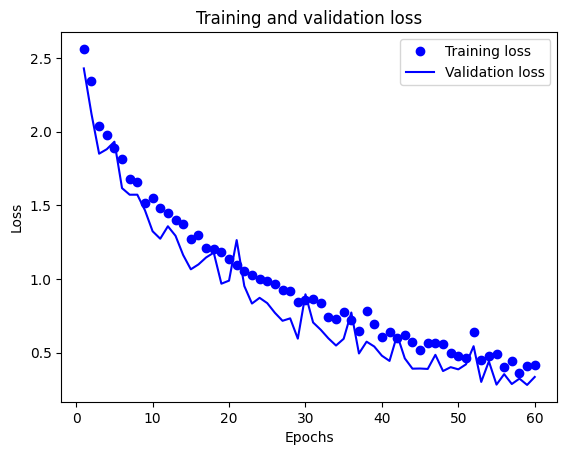

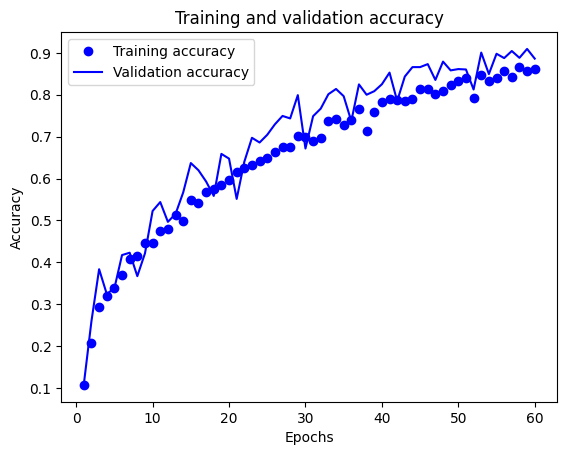

In [91]:
import matplotlib.pyplot as plt

# Mengambil nilai loss dan val_loss dari history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Mengambil nilai accuracy dan val_accuracy dari history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Menentukan jumlah epoch
epochs = range(1, len(loss) + 1)

# Menampilkan plot loss
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Menampilkan plot accuracy
plt.figure()
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# 🔮Making predictions on the Test Data

In [94]:
# Memuat model yang sudah dilatih
model = tf.keras.models.load_model('model.h5')

# Melakukan prediksi pada data uji
pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)

# Mengambil label sebenarnya dari data uji
y_true = test_generator.classes

# Mengambil nama kelas
class_names = list(test_generator.class_indices.keys())

# Menampilkan hasil prediksi
for i in range(len(y_true)):
    image_name = test_generator.filenames[i]
    true_label = class_names[y_true[i]]
    predicted_label = class_names[y_pred[i]]
    print(f"Image {image_name}: True Label = {true_label}, Predicted Label = {predicted_label}")


132/132 [==============================] - 11s 80ms/step
Image Albino/Albino_original_Alb_(1).jpg_169b6939-a618-444d-9f96-71cff5c65081.jpg: True Label = Albino, Predicted Label = Albino
Image Albino/Albino_original_Alb_(1).jpg_290ee42f-e64e-4231-9f9e-535c0daa75f2.jpg: True Label = Albino, Predicted Label = Albino
Image Albino/Albino_original_Alb_(1).jpg_4b6f90da-bca2-437c-a017-aea66f23da5a.jpg: True Label = Albino, Predicted Label = Albino
Image Albino/Albino_original_Alb_(1).jpg_82e670f0-bccf-4143-a2bd-9200e799281f.jpg: True Label = Albino, Predicted Label = Albino
Image Albino/Albino_original_Alb_(1).jpg_c89800ac-9d1e-43dc-a096-0a92f3b69288.jpg: True Label = Albino, Predicted Label = Albino
Image Albino/Albino_original_Alb_(1).jpg_c95f254d-695d-4860-91de-c55f8b2de158.jpg: True Label = Albino, Predicted Label = Albino
Image Albino/Albino_original_Alb_(1).jpg_d134540b-7ec8-4cfd-937f-02060b6d666c.jpg: True Label = Albino, Predicted Label = Albino
Image Albino/Albino_original_Alb_(10).jp

## masih error

132/132 [==============================] - 10s 78ms/step


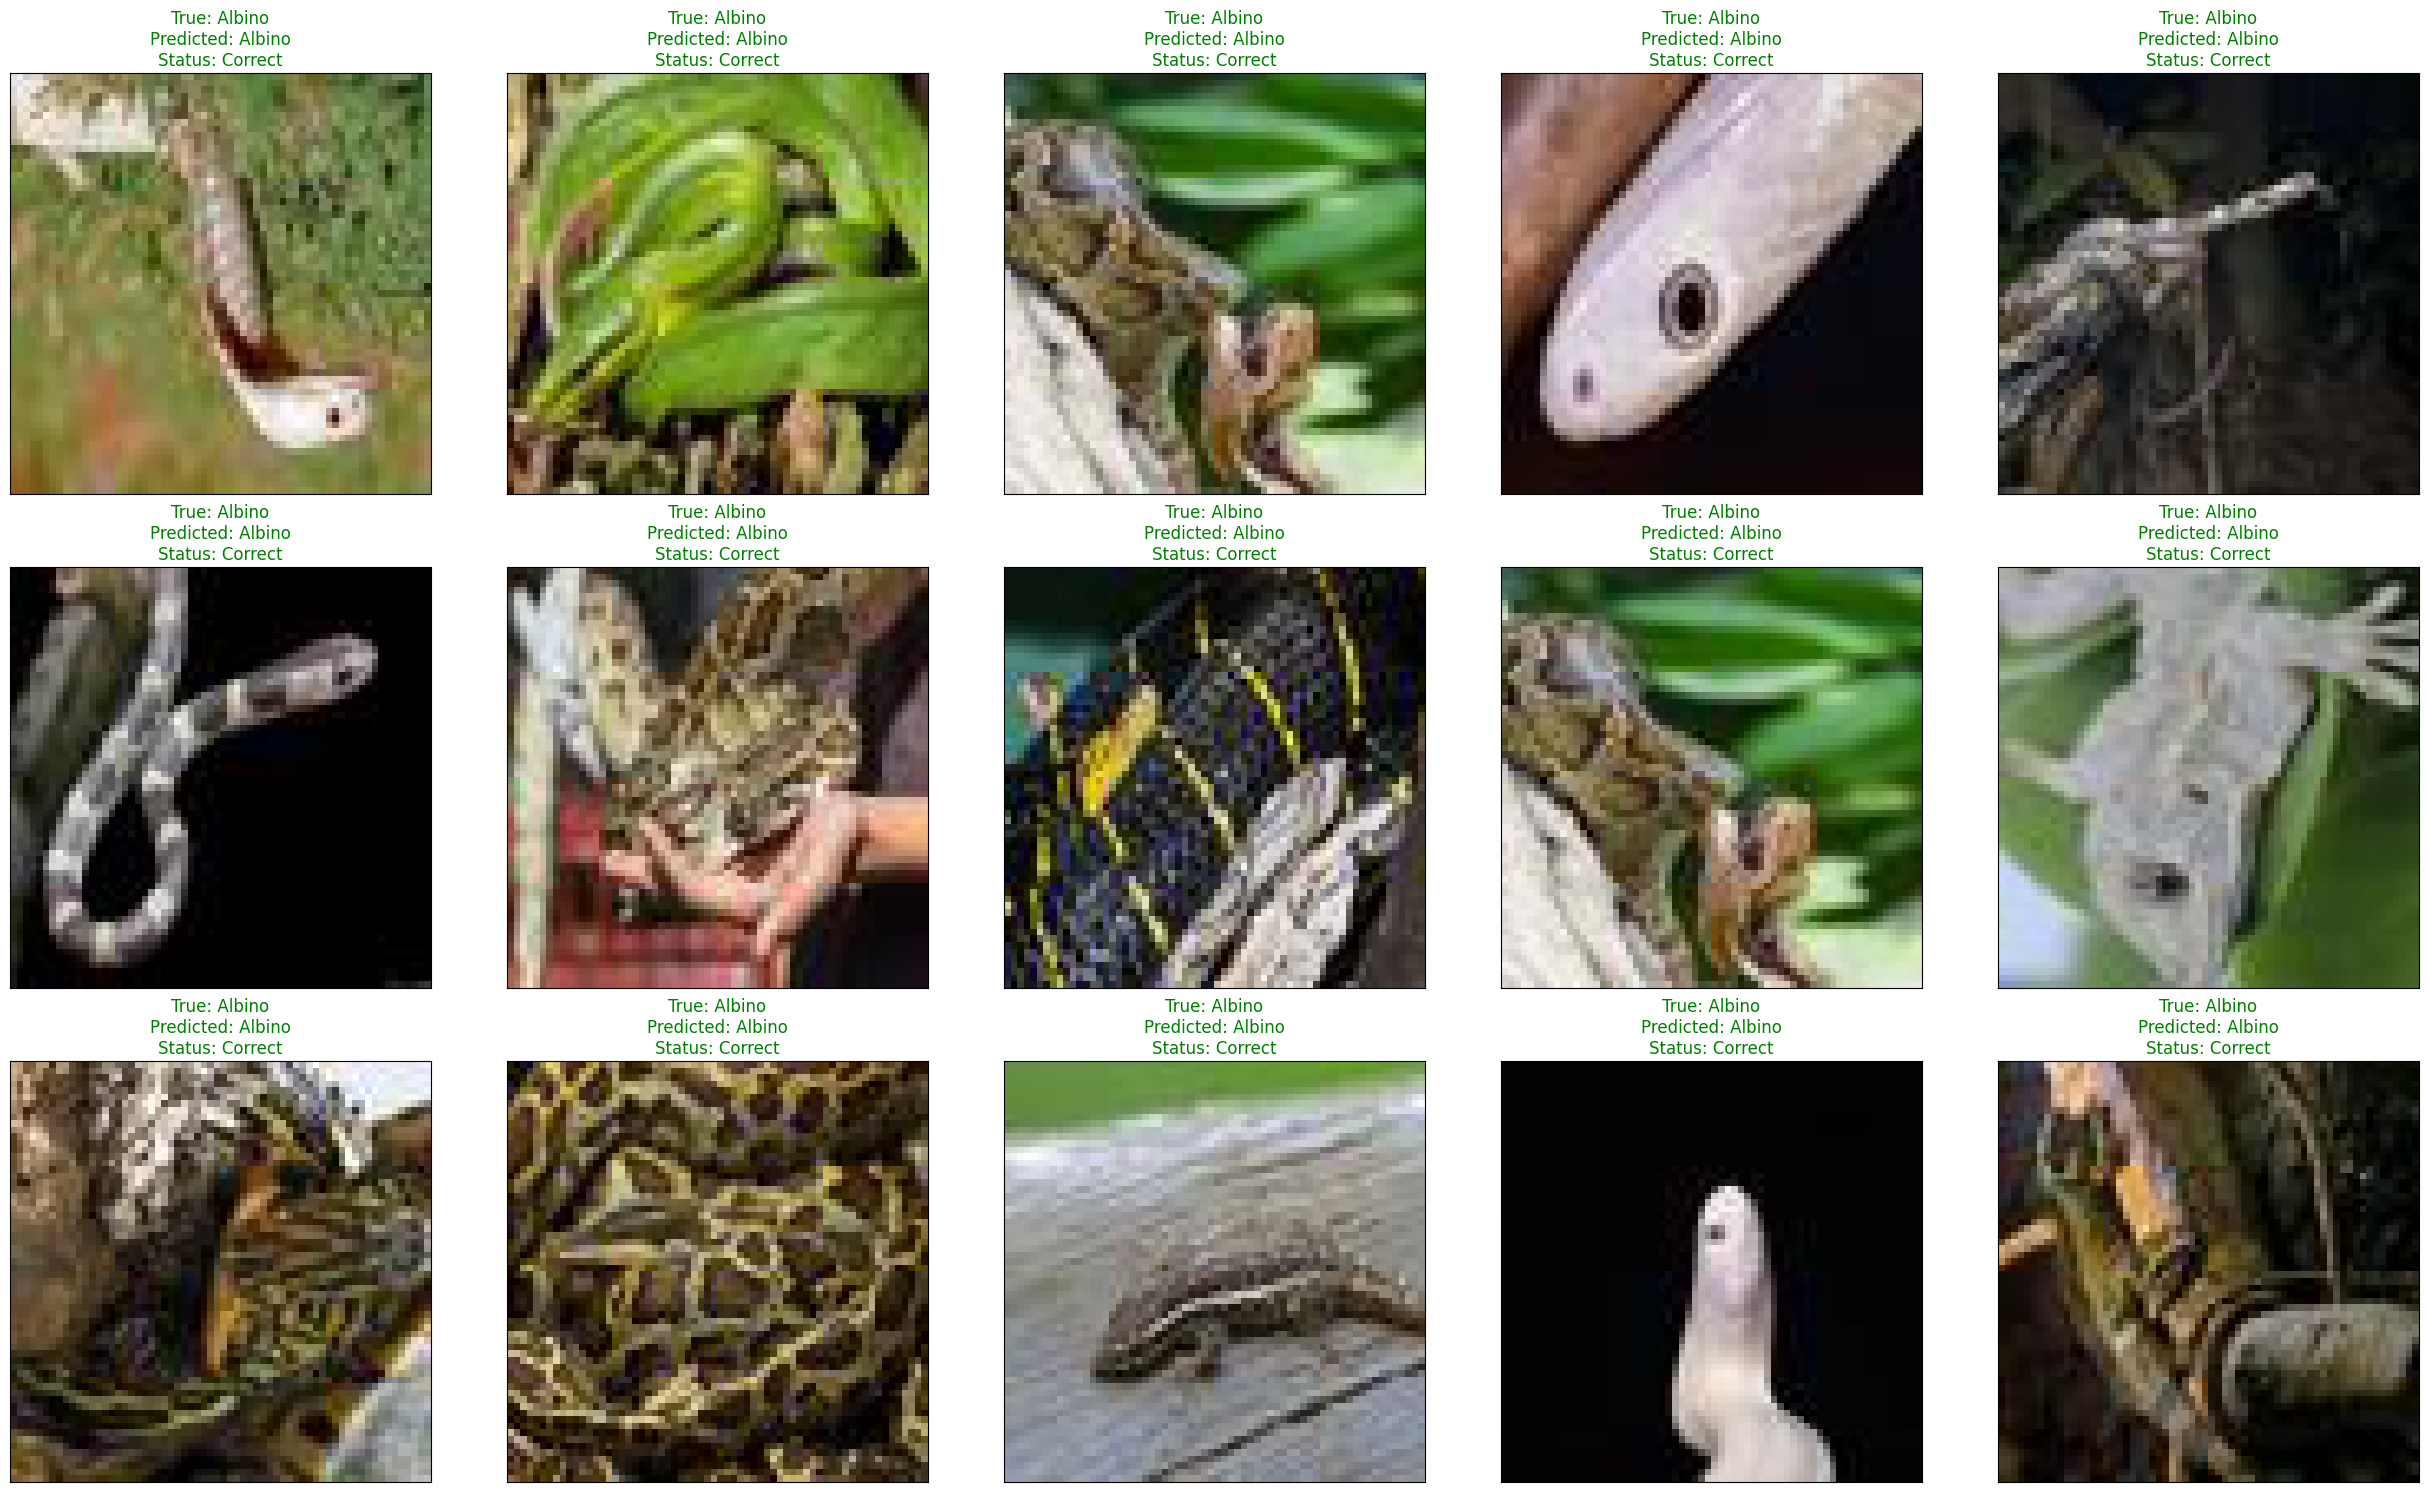

In [98]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Memuat model yang sudah dilatih
model = tf.keras.models.load_model('model.h5')

# Menentukan jumlah gambar yang akan ditampilkan
num_images = 15

# Mengambil indeks acak
random_index = np.random.randint(0, len(test_generator), num_images)

# Mengambil label sebenarnya dari data uji
y_true = test_generator.classes[random_index]

# Melakukan prediksi pada data uji
pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)

# Mengambil nama kelas
class_names = list(test_generator.class_indices.keys())

# Menampilkan gambar dengan label, prediksi, dan status prediksi
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    batch_images, _ = test_generator[random_index[i]]
    image = batch_images[6]  # Mengambil gambar pertama dari batch
    true_label = class_names[y_true[i]]
    predicted_label = class_names[y_pred[i]]
    prediction_status = "Correct" if true_label == predicted_label else "Incorrect"
    color = "green" if prediction_status == "Correct" else "red"
    ax.imshow(image)
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}\nStatus: {prediction_status}", color=color)

plt.tight_layout()
plt.show()


132/132 [==============================] - 11s 80ms/step


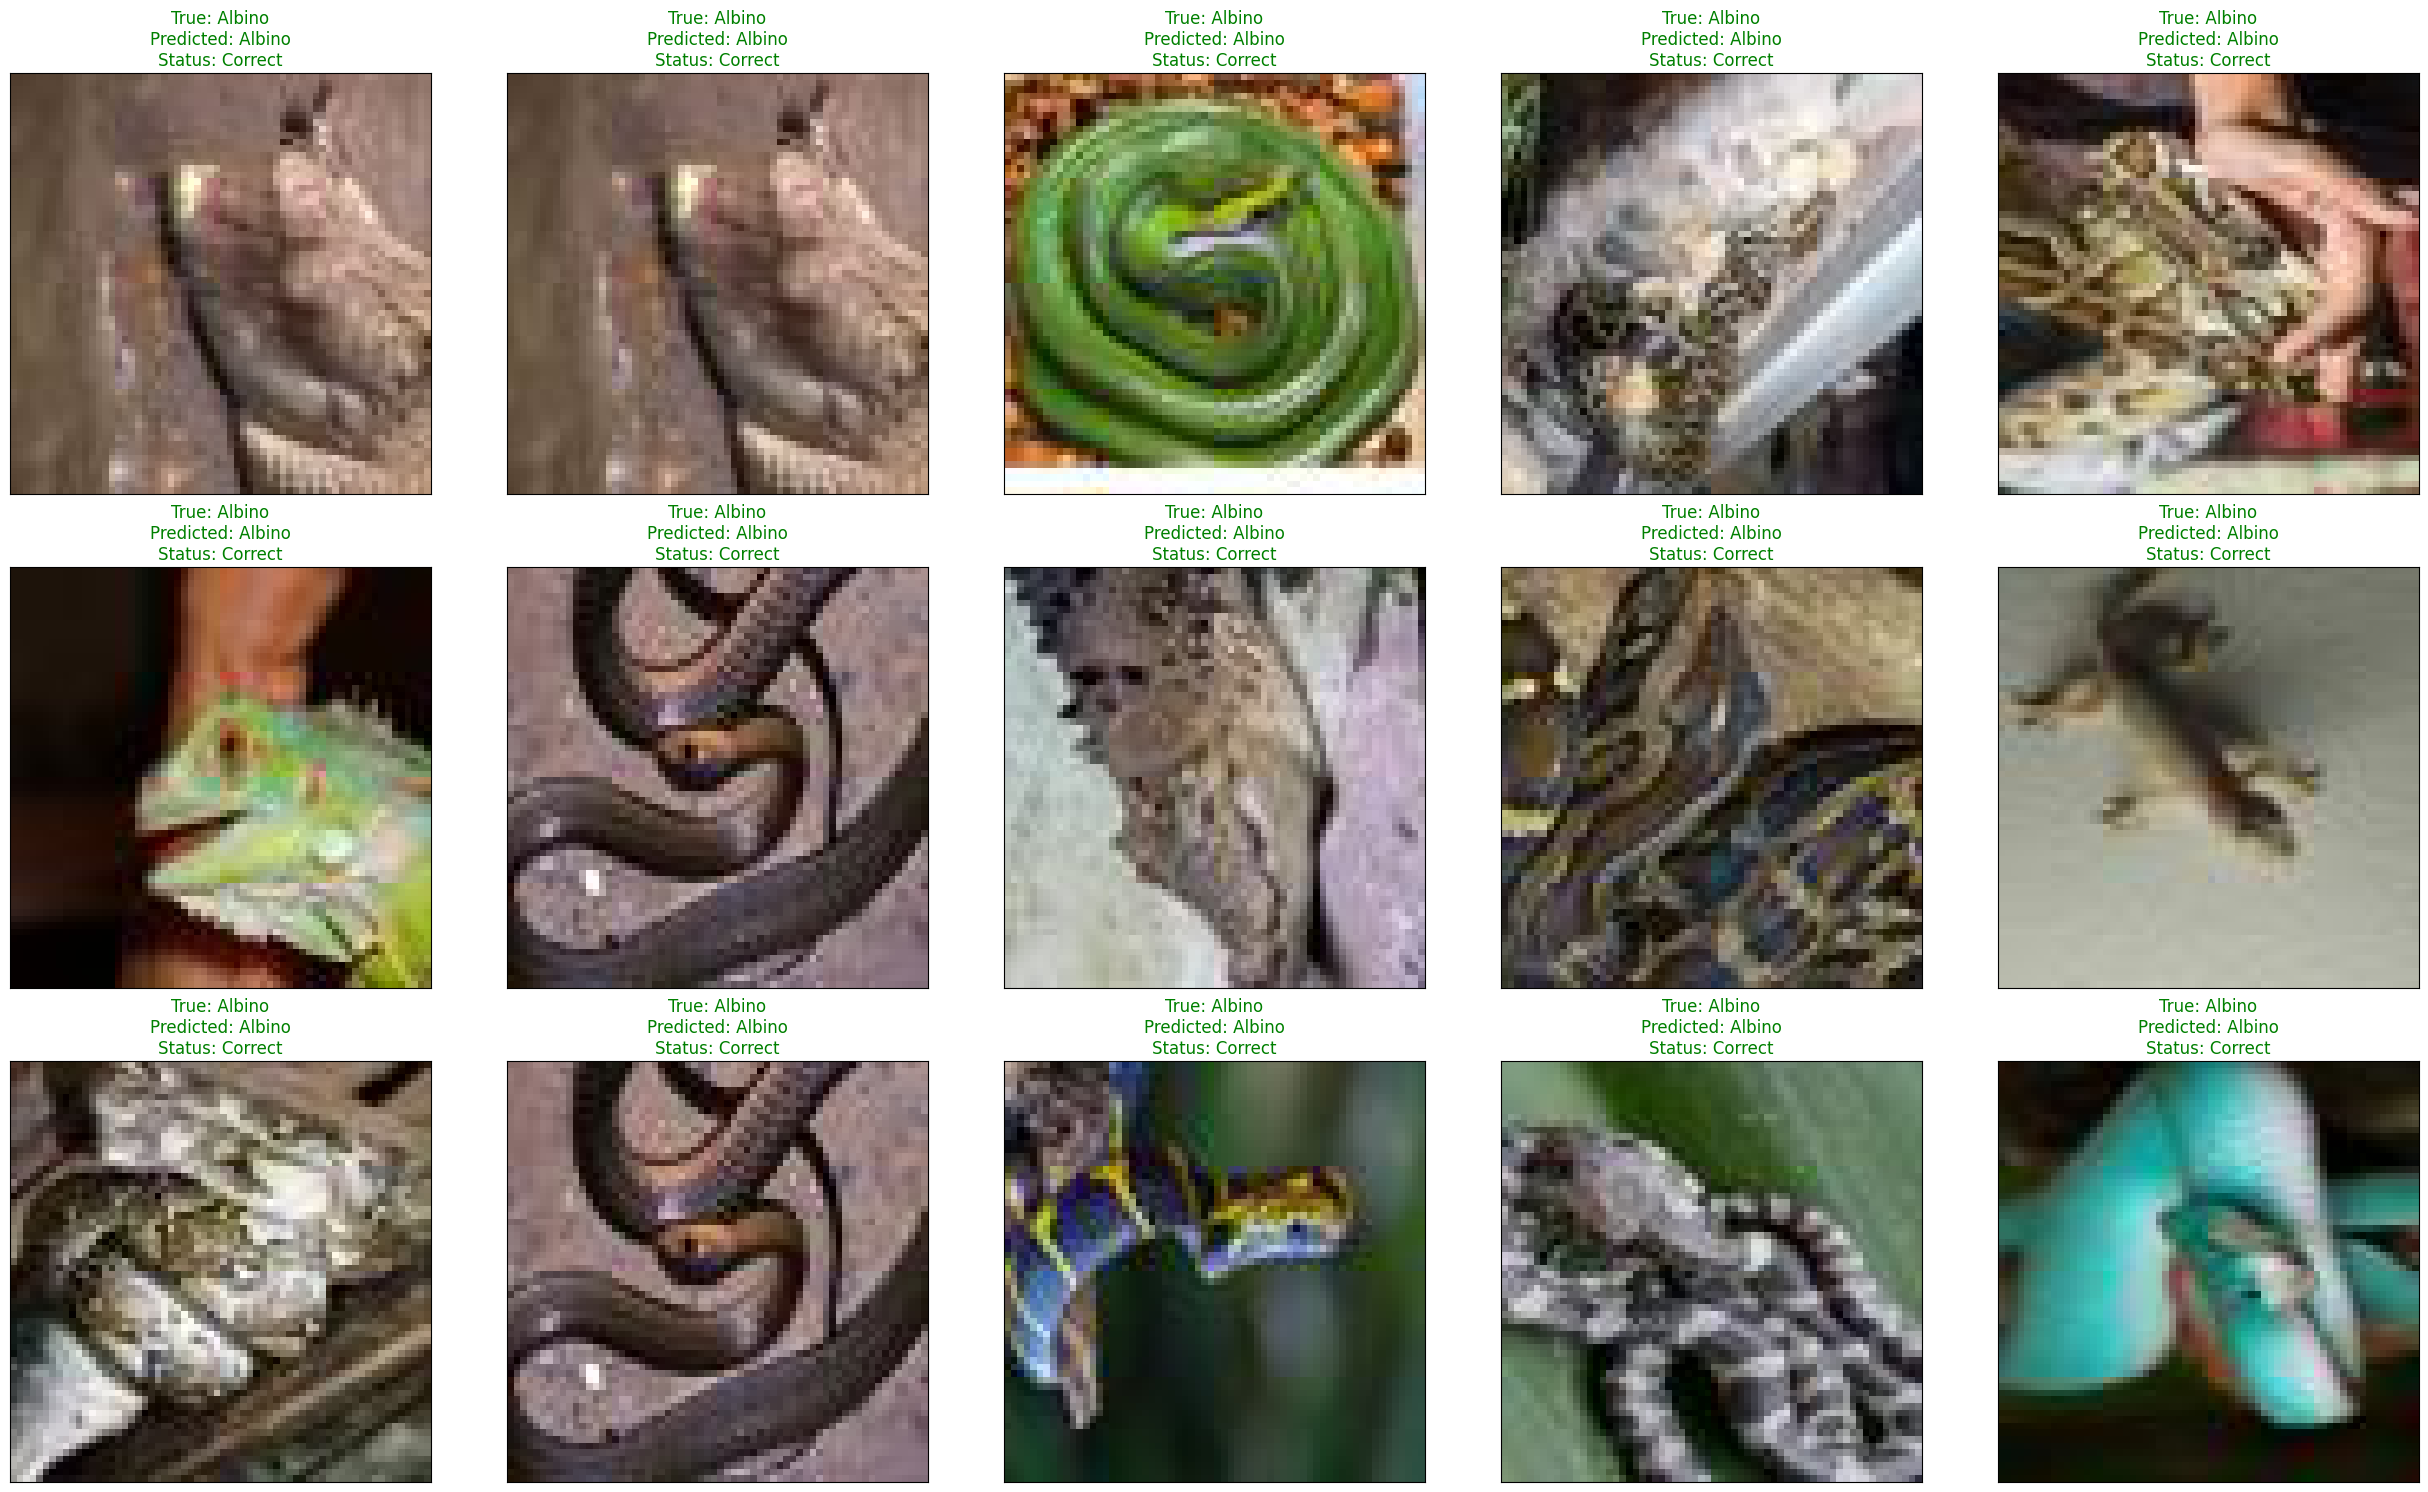

In [93]:
import matplotlib.pyplot as plt
import numpy as np


# Memuat model yang sudah dilatih
model = tf.keras.models.load_model('model.h5')

# Menentukan jumlah gambar yang akan ditampilkan
num_images = 15

# Mengambil indeks acak
random_index = np.random.randint(0, len(test_generator), num_images)

# Mengambil label sebenarnya dari data uji
y_true = test_generator.classes[random_index]

# Melakukan prediksi pada data uji
pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)

# Mengambil nama kelas
class_names = list(test_generator.class_indices.keys())

# Menampilkan gambar dengan label, prediksi, dan status prediksi
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    batch_images, _ = test_generator[random_index[i]]
    image = batch_images[0]  # Mengambil gambar pertama dari batch
    true_label = class_names[y_true[i]]
    predicted_label = class_names[y_pred[i]]
    prediction_status = "Correct" if true_label == predicted_label else "Incorrect"
    color = "green" if prediction_status == "Correct" else "red"
    ax.imshow(image)
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}\nStatus: {prediction_status}", color=color)

plt.tight_layout()
plt.show()


132/132 [==============================] - 10s 77ms/step


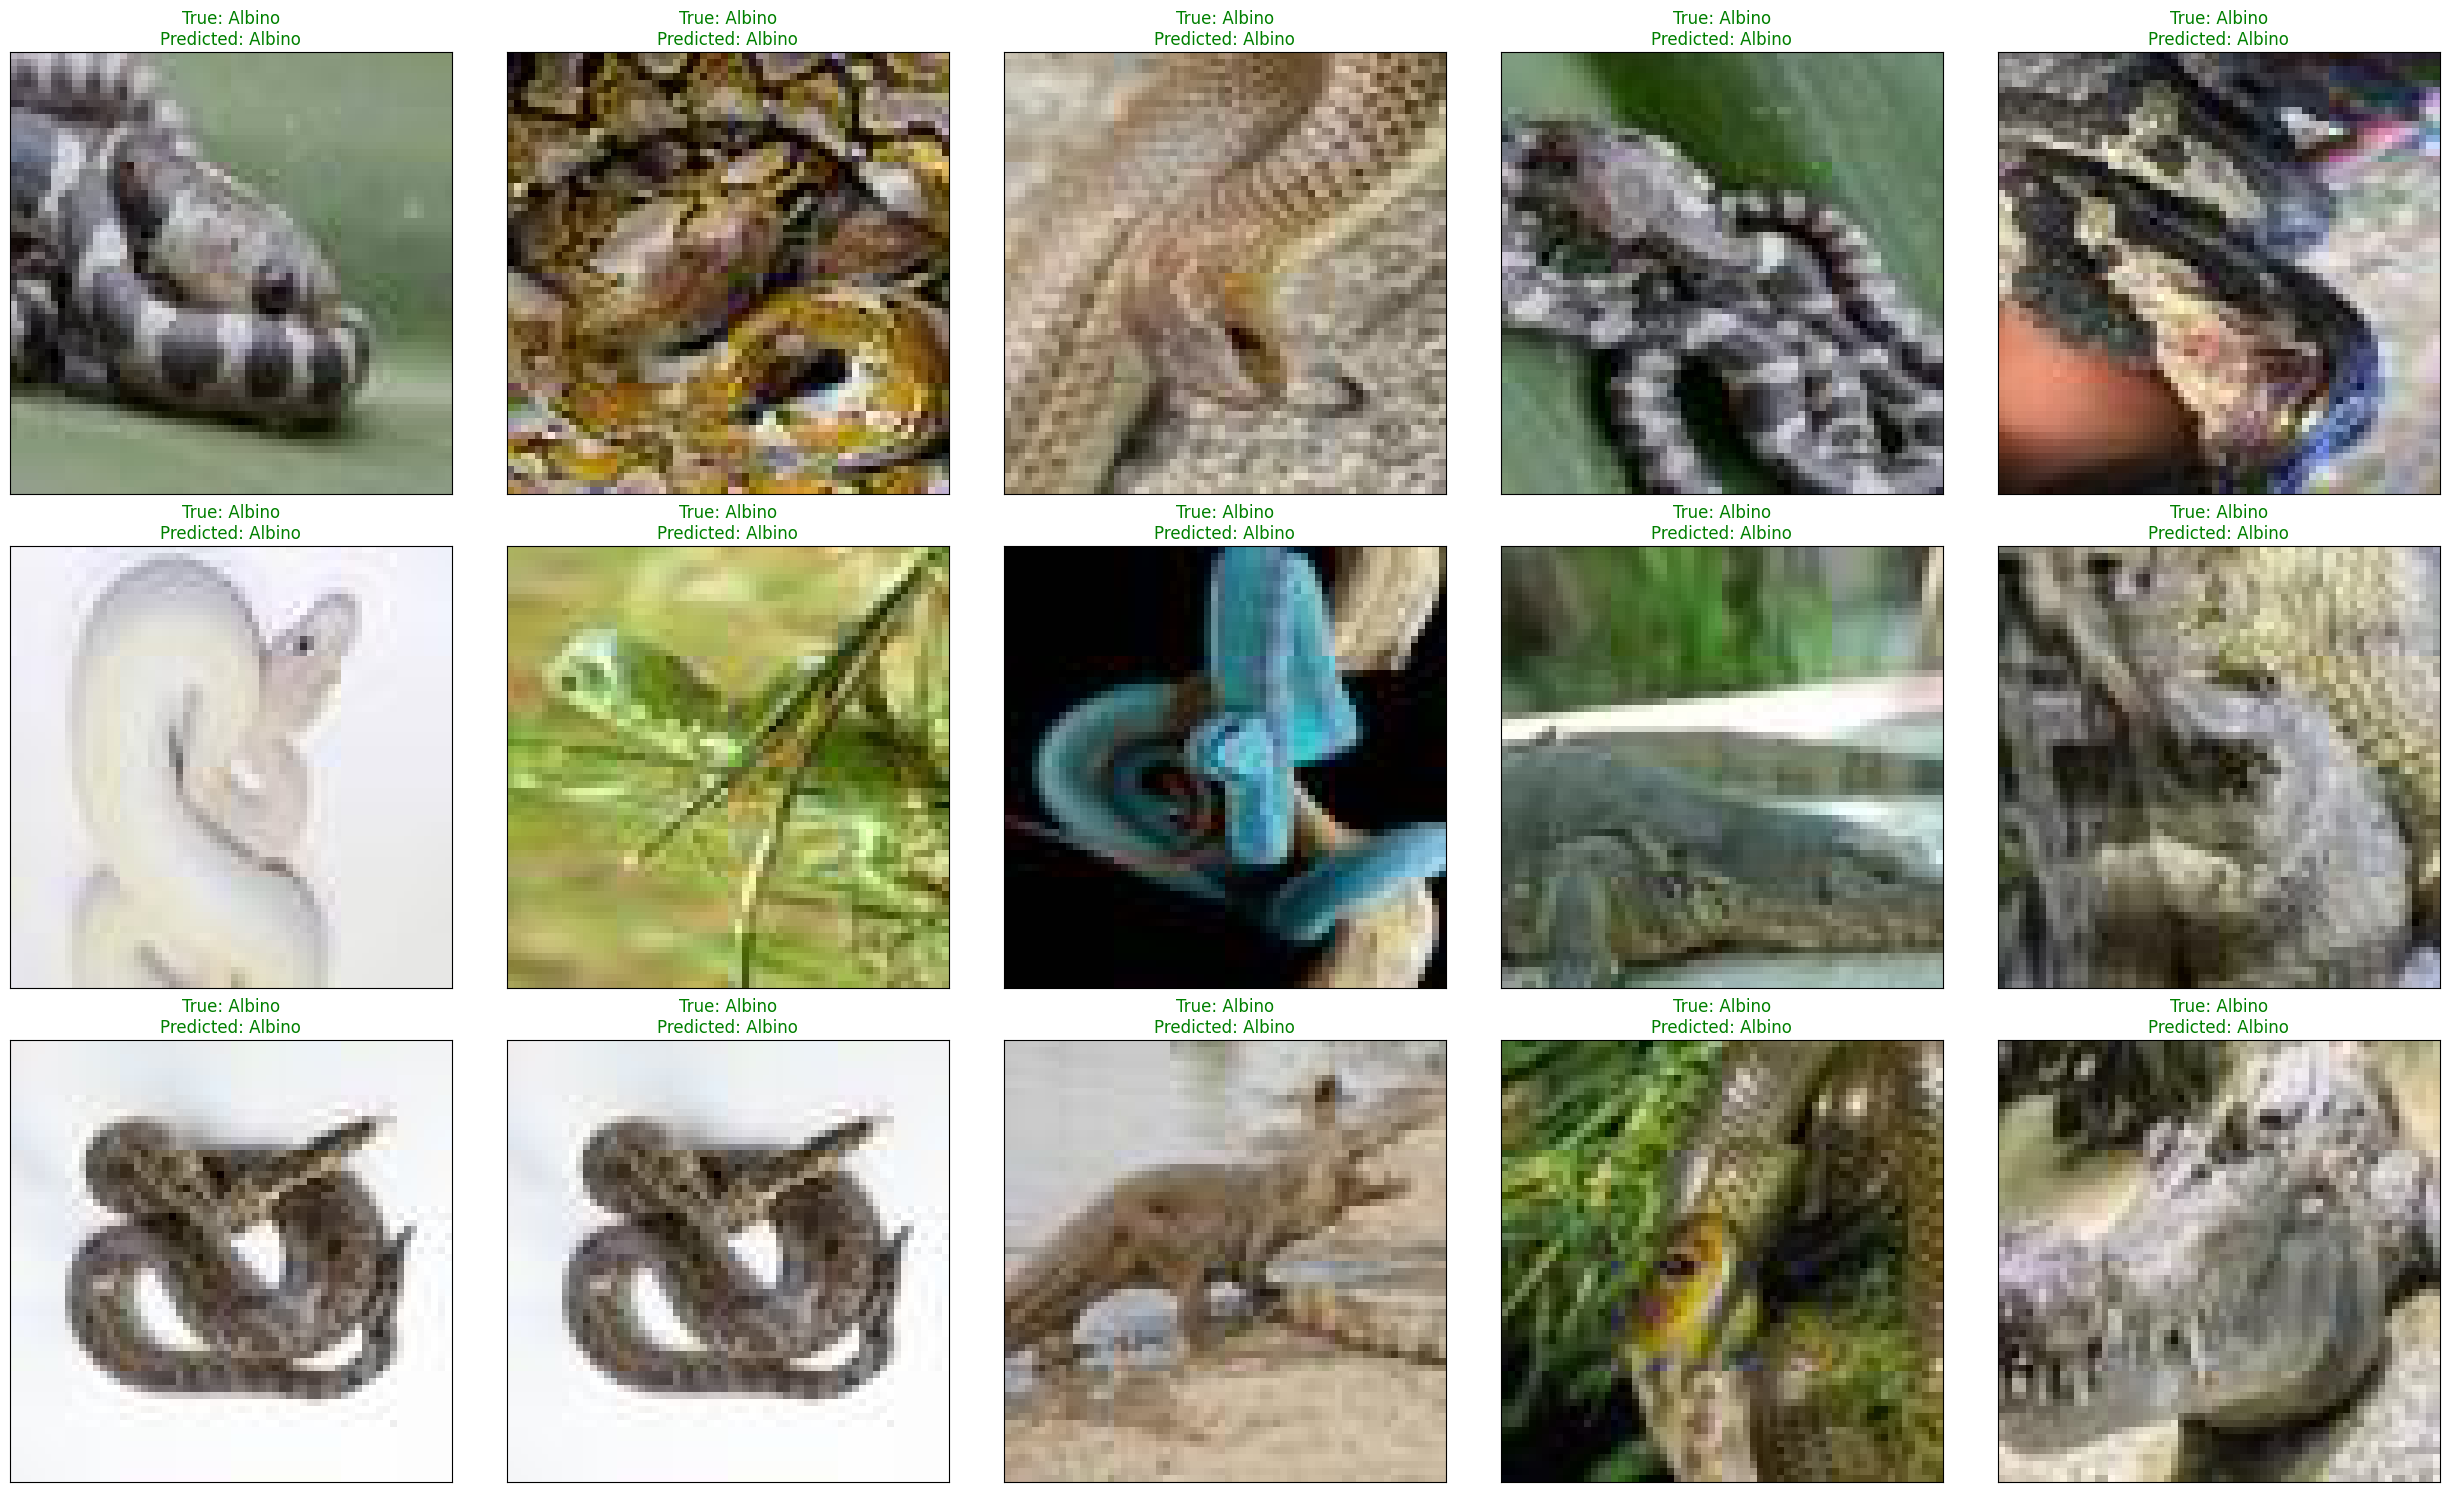

In [100]:
# ini masih salah

# Menentukan jumlah gambar yang akan ditampilkan
num_images = 15

# Mengambil indeks acak
random_index = np.random.randint(0, len(test_generator) - 1, num_images)

# Mengambil label sebenarnya dari data uji
y_true = test_generator.classes[random_index]

# Melakukan prediksi pada data uji
pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)

# Mengambil nama kelas
class_names = list(test_generator.class_indices.keys())

# Menampilkan gambar dengan label dan prediksi
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = test_generator[random_index[i]][0][0]  # Mengambil gambar dari generator
    true_label = class_names[y_true[i]]
    predicted_label = class_names[y_pred[i]]
    color = "green" if true_label == predicted_label else "red"
    ax.imshow(image)
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}", color=color)

plt.tight_layout()
plt.show()


# 📊Plotting the Classification Reports and Confusion Matrix

132/132 [==============================] - 10s 78ms/step
Classification Report:
              precision    recall  f1-score   support

      Albino       0.92      0.97      0.95       288
      Biawak       0.83      0.86      0.85       321
        Blue       0.98      1.00      0.99       289
       Burma       0.88      0.84      0.86       289
        Emas       0.99      0.94      0.96       308
      Gavial       0.76      0.84      0.80       311
       Gekko       0.96      0.84      0.90       324
   Gonyosoma       0.98      0.95      0.97       275
      Iguana       0.79      0.83      0.81       332
        Jali       0.91      0.88      0.90       309
     Kembang       0.83      0.75      0.79       302
       Perak       0.81      0.95      0.87       309
    Siamesis       0.79      0.85      0.82       263
 Testudinata       0.91      0.80      0.85       280

    accuracy                           0.88      4200
   macro avg       0.88      0.88      0.88      4200


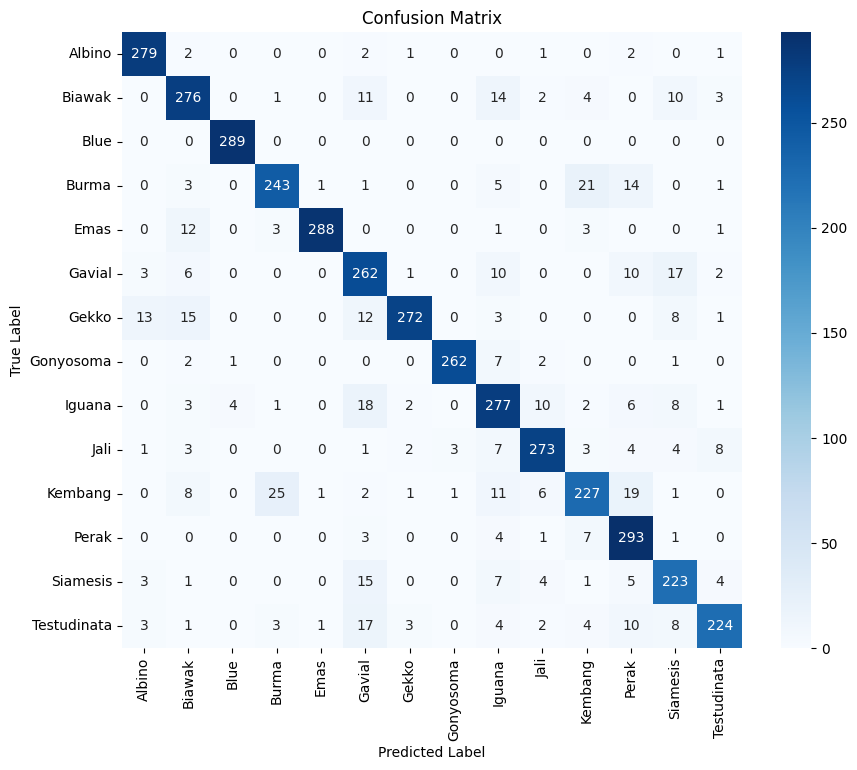

In [106]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Mengambil label sebenarnya dari data uji
y_true = test_generator.classes

# Melakukan prediksi pada data uji
pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)

# Membuat Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Membuat Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Menampilkan Confusion Matrix menggunakan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [105]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
y_test = list(test_dir.Label)
print(classification_report(y_test, pred))



AttributeError: ignored

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()